Submittion with F1-Macro of 0.50507

In [311]:
import pycaret
from pycaret.classification import *

pycaret.__version__

'3.1.0'

In [312]:
import pandas as pd
import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [313]:
data_train = pd.read_parquet('train_v2.gzip')
data_test = pd.read_parquet('test_v2.gzip')
data_test_id = data_test[['ID']]

for col in ['CO_TIPO_SEXO', 'ANIO_BANCARIZACION', 'MES_BANCARIZACION']:
    data_train[col] = data_train[col].astype('category')
    data_test[col] = data_test[col].astype('category')

TARGET_VAR = 'TARGET'
N_FOLDS = 5

In [314]:
data_train.dtypes

ID                                         object
TARGET                                      int64
CO_TIPO_SEXO                             category
EDAD                                      float64
ANIO_BANCARIZACION                       category
MES_BANCARIZACION                        category
CANT_EMP_NEG_max                            int64
CANT_EMP_NEG_last                           int64
CANT_EMP_CONS_max                           int64
CANT_EMP_CONS_last                          int64
CANT_EMP_HIPOT_max                          int64
CANT_EMP_HIPOT_last                         int64
CANT_MESES_SALDO_VENCIDO_max                int64
SALDO_MED_EMP_mean                        float64
SALDO_PEQ_EMP_mean                        float64
SALDO_MIC_EMP_mean                        float64
SALDO_CONS_REV_mean                       float64
SALDO_CONS_NO_REV_mean                    float64
SALDO_HIPOT_mean                          float64
SALDO_VENCIDO_mean                        float64


In [315]:
# get only numeric columns
categorical_feats = ['CO_TIPO_SEXO', 'ANIO_BANCARIZACION', 'MES_BANCARIZACION']
data = data_train.select_dtypes(include=['int64', 'float64', 'category'])# pd.concat([data_train.select_dtypes(include=['int64', 'float64']), data_train['ID']], axis=1)
#data = data.drop(columns=['EDAD'])
exclude_substr_list = ['PROXY_', '_1', '_MA3', '_MA6', '_min', '_median', '_last']
#data = data.drop(columns=['CANT_EMP_NEG_max'])
data = data[[col for col in data.columns if all([sub not in col for sub in exclude_substr_list])]]

data_test = data_test.select_dtypes(include=['int64', 'float64', 'category'])
#data_test = data_test.drop(columns=['EDAD'])
#data_test = data_test.drop(columns=['CANT_EMP_NEG_max'])
data_test = data_test[[col for col in data_test.columns if all([sub not in col for sub in exclude_substr_list])]]

print(data.columns)

Index(['TARGET', 'CO_TIPO_SEXO', 'EDAD', 'ANIO_BANCARIZACION',
       'MES_BANCARIZACION', 'CANT_EMP_NEG_max', 'CANT_EMP_CONS_max',
       'CANT_EMP_HIPOT_max', 'CANT_MESES_SALDO_VENCIDO_max',
       'SALDO_MED_EMP_mean', 'SALDO_PEQ_EMP_mean', 'SALDO_MIC_EMP_mean',
       'SALDO_CONS_REV_mean', 'SALDO_CONS_NO_REV_mean', 'SALDO_HIPOT_mean',
       'SALDO_VENCIDO_mean', 'SALDO_EMP_TOTAL_mean',
       'VAR_SALDO_EMP_TOTAL_MA8_mean', 'VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_mean',
       'VAR_SALDO_REV_NO_REV-VENCIDO_MA8_mean',
       'VAR_SALDO_TOTAL-VENCIDO_MA8_mean'],
      dtype='object')


In [316]:
# perform min max normalization in all columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.copy()

data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled[TARGET_VAR] = data_train[TARGET_VAR]

In [318]:
data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [320]:
data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [321]:
s = setup(data_scaled, target=TARGET_VAR, session_id=123, use_gpu=True, fold=N_FOLDS, categorical_features=categorical_feats)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(91183, 21)"
4,Transformed data shape,"(91183, 49)"
5,Transformed train set shape,"(63828, 49)"
6,Transformed test set shape,"(27355, 49)"
7,Numeric features,17
8,Categorical features,3
9,Rows with missing values,16.8%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

In [324]:
# add F1 macro to metrics
from sklearn.metrics import f1_score, make_scorer

try:
    def f1_macro(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    add_metric('f1_macro', 'F1 Macro', f1_macro, greater_is_better=True)
except:
    pass

In [325]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7c3a3de7ca60>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7c3a3de7cb80>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7c3a3de7cca0>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f1_macro,F1 Macro,F1 Macro,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f1_macro),pred,{},True,True,True


In [326]:
all_models = models()
all_models

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [327]:
best = compare_models(sort='F1 Macro', exclude=['knn', 'svm', 'rbfsvm', 'dummy', 'lda', 'lr', 'nb', 'ridge', 'qda', 'gpc', 'et'], fold=N_FOLDS)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8683,0.8067,0.2849,0.6362,0.3935,0.3315,0.3654,0.6598,1.3100
lightgbm,Light Gradient Boosting Machine,0.8715,0.8166,0.2685,0.6822,0.3853,0.3284,0.3733,0.6568,0.9960
rf,Random Forest Classifier,0.8691,0.7968,0.2597,0.6631,0.3732,0.3154,0.3590,0.6501,8.9280
gbc,Gradient Boosting Classifier,0.8697,0.8154,0.2570,0.6723,0.3719,0.3150,0.3608,0.6496,17.8240
ada,Ada Boost Classifier,0.8663,0.8067,0.2493,0.6396,0.3586,0.2997,0.3416,0.6420,4.6000
dt,Decision Tree Classifier,0.7993,0.6186,0.3605,0.3406,0.3502,0.2317,0.2318,0.6158,1.6560


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [328]:
# tuned_model = tune_model(best, optimize='F1 Macro')

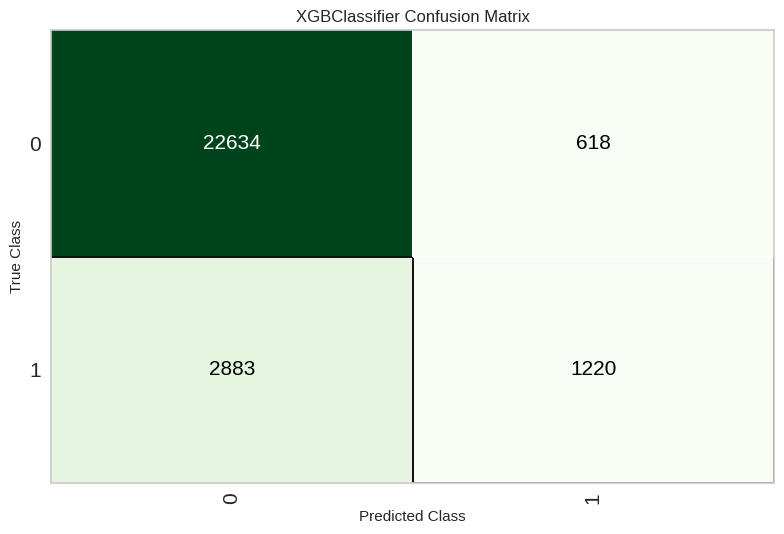

In [329]:
plot_model(best, plot='confusion_matrix')

In [330]:
# plot_model(best, plot='learning')

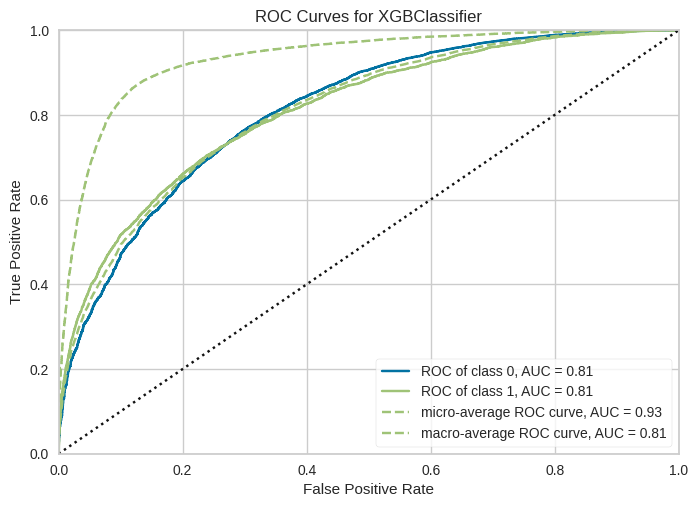

In [331]:
plot_model(best, plot='auc')

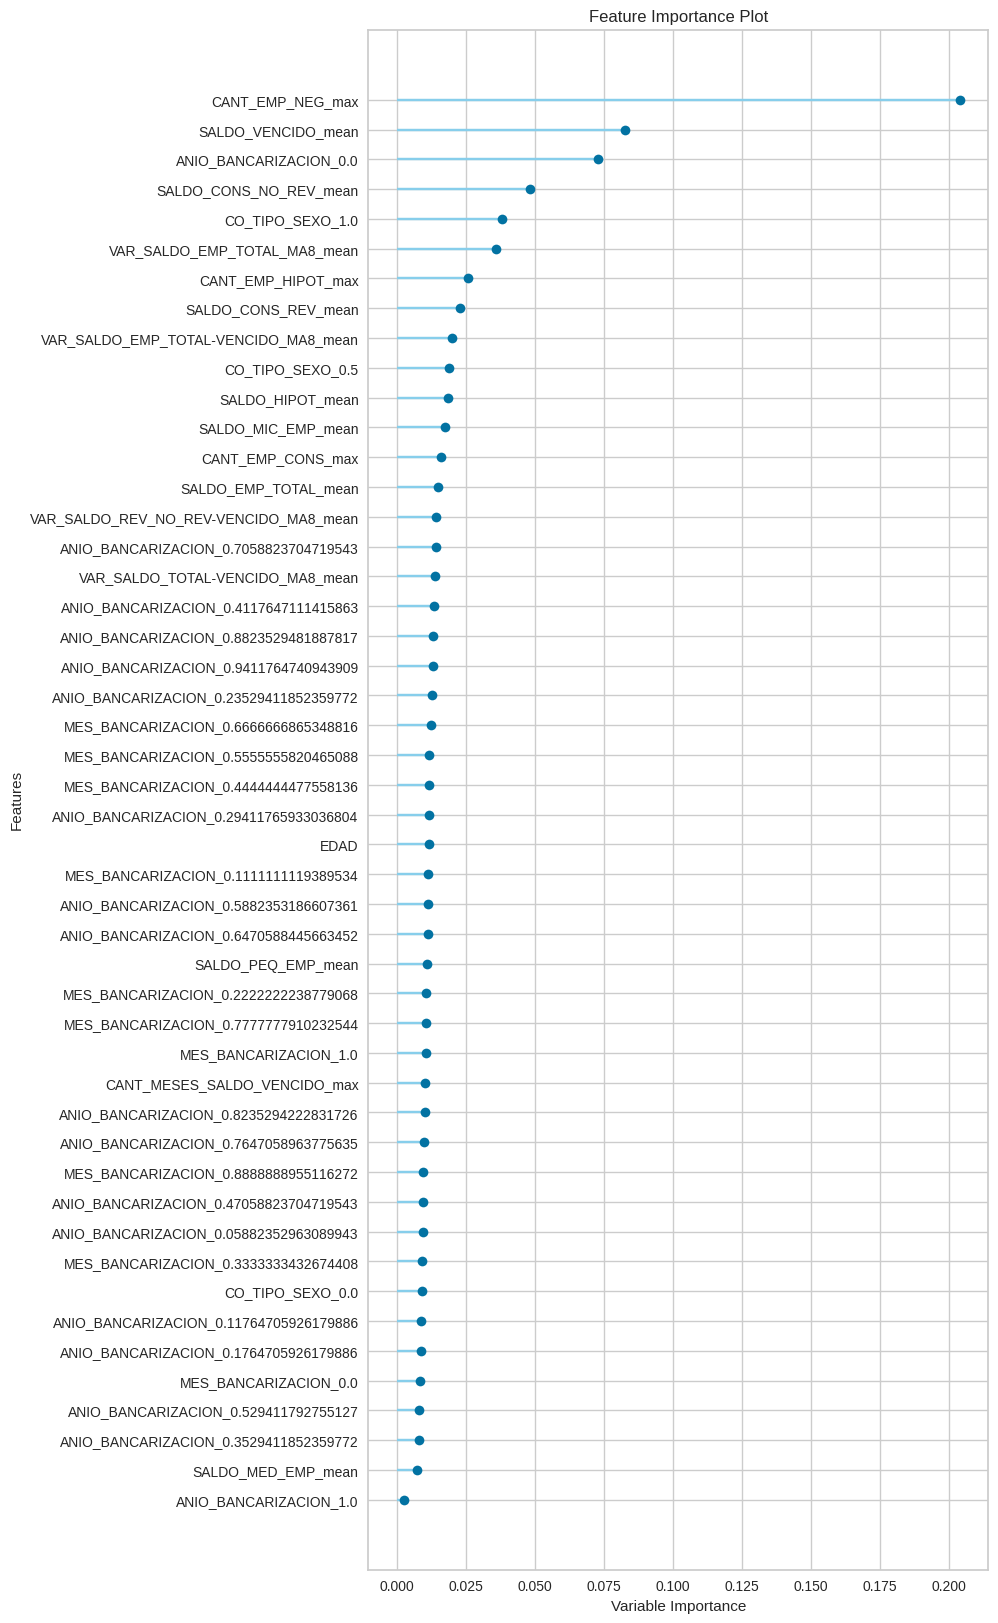

In [332]:
try:
    plot_model(best, plot='feature_all')
except:
    pass

In [333]:
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Extreme Gradient Boosting,0.8720,0.8120,0.2973,0.6638,0.4107,0.3504,0.3862,0.6695


In [334]:
predictions_train = predict_model(best, data=data_scaled)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Extreme Gradient Boosting,0.8879,0.8722,0.3563,0.7744,0.4880,0.4346,0.4761,0.7125


In [335]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(predictions_train[TARGET_VAR], predictions_train['prediction_label'], normalize='true')
cm = pd.DataFrame(cm, columns=['0', '1'])
cm.index = ['0', '1']
display(cm)

print(classification_report(predictions_train[TARGET_VAR], predictions_train['prediction_label']))

,0,1
0,0.981679,0.018321
1,0.643734,0.356266


              precision    recall  f1-score   support

           0       0.90      0.98      0.94     77505
           1       0.77      0.36      0.49     13678

    accuracy                           0.89     91183
   macro avg       0.84      0.67      0.71     91183
weighted avg       0.88      0.89      0.87     91183



In [336]:
predictions = predict_model(best, data=data_test.drop(columns=[TARGET_VAR]))

In [337]:
predictions['prediction_label'].value_counts(normalize=True)

0   0.563029
1   0.436971
Name: prediction_label, dtype: float64

In [282]:
now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

In [283]:
pd.concat([data_test_id, predictions[['prediction_label']]], axis=1).rename(columns={'prediction_label': TARGET_VAR}).to_csv(f'./submission_{now}.csv', index=False)  # , 'prediction_score'